<center><h1>Experiments on SC09 Dataset</h1></center>

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd
from torchaudio.functional import mu_law_encoding, mu_law_decoding
from scipy.io import wavfile

# Custom modules
from sashimi import *
from wav_dataset import *

Using PyKeOps Cauchy kernel.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Dataset

SC09 is a dataset containing 1 second audio recordings of spoken digits, 0 to 9.

In [4]:
train_dataset = SC09("./datasets/sc09/train", device=device)

WAV files in directory: 5965
729 WAV file(s) were discarded because they were not 1 second long.


In [5]:
len(train_dataset)

5236

In [6]:
x, y = train_dataset[0]
assert list(x.size()) == [16000]
assert list(y.size()) == [16000]

`y` contains all samples 0 to N in the sound file, each sample is an integer between 0 and 255. `x`, on the other hand, contains samples 0 to N-1, each sample is an integer between 0 to 255. For each input sample $i$, the network predicts the probabilities for the next sample ($i+1$) in 8-bits using the inputs from $0$ to $i$.

Let's listen to one of the sound files in the dataset:

In [7]:
ipd.Audio(mu_law_decoding(x, 256).cpu().numpy(), rate=16000)

Check whether the labels are encoded correctly using [mu-law](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm).

In [8]:
ipd.Audio(mu_law_decoding(y, 256).cpu().numpy(), rate=16000)

# The Model

Here, we define the SaShiMi model with the hyperparameters given in Appendix C.2.1.

In [9]:
torch.manual_seed(42)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000,
    block_count=4,
    encoder=Embedding(256, 64),
).to(device)

For "simplicity", they don't train the low-rank term $pp^*$, the $B$ matrix and the timescale $\Delta$. In some of our full dataset experiments, we do the same, but we still train $\Delta$ because they don't provide the initial value for that parameter.

In [10]:
for module in model.modules():
    # isinstance doesn't work due to automatic reloading
    if type(module).__name__ == S4Base.__name__:
        module.B.requires_grad = False
        module.P.requires_grad = False

Let's inspect the number of parameters in our model:

In [11]:
print("Total parameters:", sum([i.nelement() for i in model.parameters()]))
print("Parameters to be learned:", sum([i.nelement() if i.requires_grad else 0 for i in model.parameters()]))

Total parameters: 2332300
Parameters to be learned: 2101388


# Training the Model: Overfitting Test

In accordance with the well-respected 796 tradition, we first test whether the model works by trying to overfit into a single example.

In [12]:
x, y = train_dataset[0]
overfit_dataset = [(x, y)]

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

You can run the following block multiple times to train the same model without restarting:

  0%|          | 0/500 [00:00<?, ?it/s]

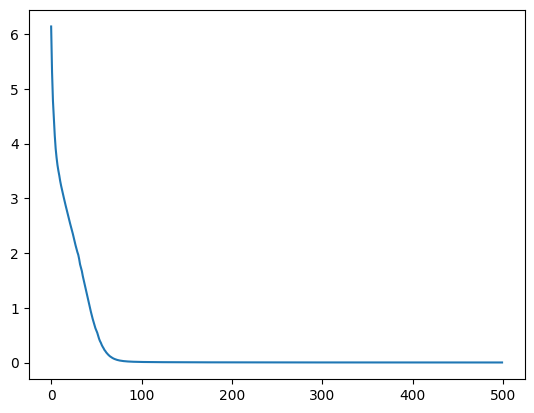

In [14]:
model.train()
for epoch in tqdm(range(500), leave=False):
    for x, y in overfit_dataset:
        y_hat = model(x)
        loss = criterion(y_hat.view(-1, 256), y.view(-1))

        loss_val = loss.detach().cpu().item()
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(losses)
plt.show()

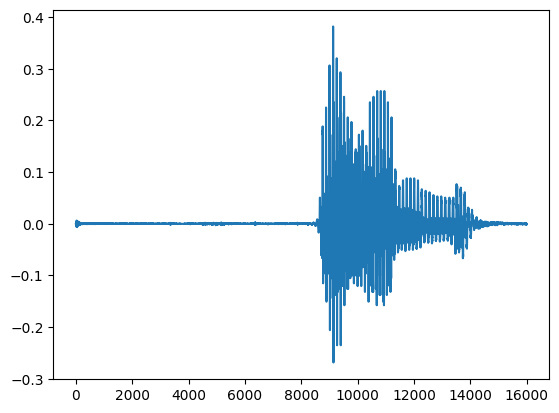

In [15]:
model.eval()
with torch.no_grad():
    train_loss = 0.0
    for x, y in overfit_dataset:
        y_hat = model(x)
        gen = mu_law_decoding(torch.argmax(y_hat, dim=-1), 256.0)
        gen = gen.flatten().cpu()

plt.figure()
plt.plot(gen)
ipd.Audio(gen.numpy(), rate=16000)

In [16]:
(gen.cuda() - mu_law_decoding(y, 256)).abs().max()

tensor(0., device='cuda:0')

## Sampling

The following method will autoregressively sample from the given model `m`. It can optionally use a priming signal to start with. When `maxp` is `True`, it will always choose the value with highest probability instead of random sampling.

In [17]:
def generate_sample(m, count: int, priming_signal=None, maxp=False):
    f = m.get_recurrent_runner()
    # The input is padded with 0 at the start
    u = f(mu_law_encoding(torch.zeros(1, device=device), 256))

    # Process the priming signal if given
    if priming_signal is not None:
        for s in priming_signal:
            u = f(s)
        primed_size = priming_signal.size(0)
    else:
        primed_size = 0

    # Generate the new part
    Y = []
    for _ in tqdm(range(count - primed_size), leave=False):
        if maxp:
            p = torch.argmax(u)
        else:
            dist = torch.distributions.categorical.Categorical(probs=torch.nn.functional.softmax(u, dim=-1))
            p = dist.sample()
        Y.append(p)
        u = p.reshape(1)
        u = f(u)

    generated = torch.stack(Y).real
    if priming_signal is not None:
        priming_signal = priming_signal.flatten()
        return torch.cat([priming_signal, generated], dim=0)
    else:
        return generated

Let's generate a sample and listen to it:

  0%|          | 0/16000 [00:00<?, ?it/s]

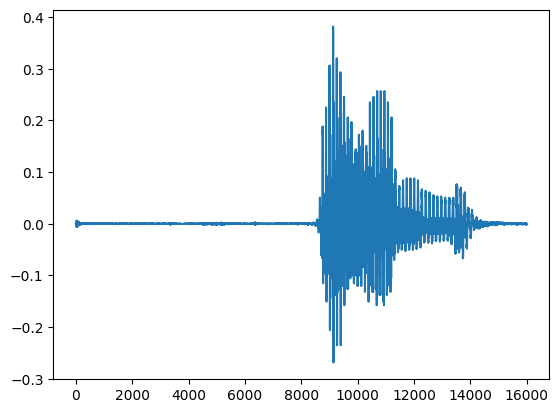

In [18]:
torch.manual_seed(42)
model.eval()
with torch.no_grad():
    #gen = generate_sample(model, 16000, train_dataset[1][0][:8000])
    gen = generate_sample(model, 16000).flatten()
    gen = mu_law_decoding(gen, 256).cpu()

plt.figure()
plt.plot(gen)
ipd.Audio(gen.numpy(), rate=16000)

We can also save it as WAV:

In [19]:
wavfile.write("overfitting.wav", 16000, gen.flatten().numpy())

# Full Dataset Training

Since training on the full dataset takes a lot of time, we won't demonstrate it in this notebook. The training code is exactly the same as above, except that we use the full dataset instead of `overfit_dataset`.

We have trained several models on the full SC09 dataset. The SaShiMi structure was the same as the model in the previous overfitting test, but with `block_count=8`.

- After epoch 120, we reduced the LR from 0.001 to 0.0005 and discarded the optimizer state since we forgot to save it. After this point, we saved the optimizer state in the checkpoints as well.
- After epoch 170, we reduced the LR to 0.0001.
- After epoch 190, we reduced the LR to 0.00001.

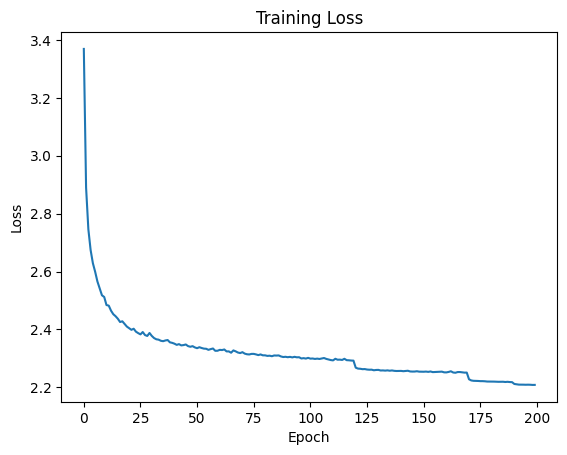

In [29]:
losses = [3.3690297760126247, 2.8898285385306557, 2.746223207284476, 2.674294201472333, 2.6287308745711813, 2.5992737884739885, 2.5656733196200303, 2.5416653219980136, 2.5180461657866267, 2.512165175321448, 2.484311910075996, 2.4823586159990034, 2.464944951406872, 2.452755857969968, 2.4458408998169063, 2.437110493019337, 2.4257174402702857, 2.428210423374904, 2.419249282174438, 2.4099165357706203, 2.4044274097180547, 2.398797211938232, 2.402534906736767, 2.39240452679059, 2.3873182353172595, 2.383066674225203, 2.3911551184326636, 2.3807028952445695, 2.3775978712635184, 2.387881219114056, 2.377652376662684, 2.370279065707258, 2.366067696891668, 2.3647815285748197, 2.360883273787171, 2.3595070939027627, 2.3620126438504867, 2.3634553126706423, 2.35553327862543, 2.3537549060719614, 2.3508553788862154, 2.34679129578685, 2.349347738819268, 2.344959924967234, 2.346036206856939, 2.3481705483589463, 2.3424794082423204, 2.340276631326166, 2.3423522050144108, 2.3379759846752837, 2.3353287711398294, 2.3387431423172695, 2.3359376819989155, 2.3337998624976355, 2.333297051364229, 2.329603817990718, 2.3321762581817977, 2.334239807565704, 2.32629284458306, 2.326457444402098, 2.3295450949486884, 2.328867859512795, 2.330859722981926, 2.3242182970046996, 2.3242085504167864, 2.319690614620238, 2.327659681189151, 2.3244607872635354, 2.320351954634863, 2.3184873979510243, 2.3215513249389996, 2.3165806666585325, 2.314368396314956, 2.3136558636454225, 2.315603643337279, 2.3156448076699525, 2.3138021851313932, 2.311458909238568, 2.313761935343269, 2.310665651678129, 2.3106226944741404, 2.308714448586675, 2.309374215766674, 2.307615401726643, 2.3101528154984687, 2.309858049145182, 2.310315565116533, 2.3067724404444223, 2.304807211606557, 2.3056163065306103, 2.3041892113576408, 2.3053184412817918, 2.303547774198401, 2.3054891917541736, 2.303780186813296, 2.3040789291148878, 2.299790440260909, 2.30088829266206, 2.2994463722214444, 2.3018831962847526, 2.299243014095394, 2.29967688367567, 2.298199411020934, 2.2992566987758374, 2.2980920121869968, 2.299785626389598, 2.3013660354468657, 2.2983207182119822, 2.296361728478934, 2.294282543568211, 2.2932025889403946, 2.2987363838967476, 2.295495274412723, 2.295762226963771, 2.294719185901962, 2.2987011356208162, 2.2939614825576315, 2.293512526359267, 2.292656731059533, 2.292309873340694, 2.2680089646623336, 2.2648552397735244, 2.2642315913702697, 2.2628477453275493, 2.2631920199357825, 2.261594606537855, 2.260940054354777, 2.261133386524579, 2.259059021491131, 2.260078050526044, 2.2603697749494596, 2.2582499944526733, 2.2585633279713058, 2.2578144268225167, 2.258679328255981, 2.257511437394237, 2.258430948330246, 2.2570993510821395, 2.256516346312661, 2.256871661885094, 2.256860502803599, 2.2558507269575396, 2.256579832812302, 2.2574061599396567, 2.2549805146137265, 2.254551750103026, 2.2546347261385153, 2.255678884309667, 2.2542725588529167, 2.254095349603027, 2.253965859376747, 2.2545147562754972, 2.253537409906169, 2.254849009841453, 2.252673731141418, 2.253022956120149, 2.2536868086298005, 2.2538215416988345, 2.25429541354871, 2.251905984732941, 2.251676211648315, 2.2532884930836334, 2.2555819040036384, 2.251362765290355, 2.2504701332281565, 2.252893920345161, 2.2529238517047796, 2.2518834035815174, 2.2509337636350675, 2.2510791996963153, 2.2278755399107024, 2.2238949611896777, 2.2226281449994967, 2.222489881151505, 2.222110748837012, 2.2214937328382303, 2.2214744955528785, 2.2210288246169343, 2.220139449789324, 2.2200891822349025, 2.219925459286639, 2.2198734045028687, 2.219472629241361, 2.219197185530917, 2.219159122823759, 2.2194113112587965, 2.218553709619828, 2.219211746718137, 2.2183598434652083, 2.2179663878360776, 2.211733098612487, 2.2104421566460877, 2.209466703975474, 2.2094987463405116, 2.2093268543709326, 2.209024379453586, 2.209271566740429, 2.2090497819521957, 2.20843830873038, 2.2085405882988267]

plt.title(label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)

# Loading a Pre-Trained Model

Let's load the second pre-trained model. Note that you should have downloaded this model using `download_data.sh`.
Note that there are other pre-trained models in `models` folder.

In [21]:
checkpoint = torch.load("./models/sc09/epoch0200.pt", map_location=device)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000,
    block_count=8,
    encoder=Embedding(256, 64),
).to(device)

model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

Now, let's sample from this model that has been trained on the full SC09 dataset.

  0%|          | 0/16000 [00:00<?, ?it/s]

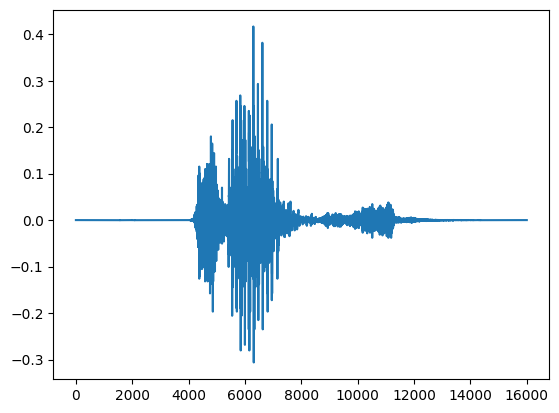

In [22]:
torch.manual_seed(42)
model.eval()
with torch.no_grad():
    #gen = generate_sample(model, 16000, train_dataset[1][0][:8000])
    gen = generate_sample(model, 16000).flatten()
    gen = mu_law_decoding(gen, 256).cpu()

plt.figure()
plt.plot(gen)
ipd.Audio(gen.numpy(), rate=16000)

In [23]:
wavfile.write("outputs/sc09/epoch200-seed42.wav", 16000, gen.numpy())

Generate en masse.

In [25]:
model.eval()
for i in tqdm(range(21), leave=False):
    torch.manual_seed(i)
    with torch.no_grad():
        gen = generate_sample(model, 16000).flatten()
        gen = mu_law_decoding(gen, 256).cpu()
    wavfile.write(f"outputs/sc09/epoch200-seed{i}.wav", 16000, gen.numpy())

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

# Reproducing the Results

## NLL Test

Next, we will compute negative log likelihood (NLL) values on the test dataset.

In [54]:
test_dataset = SC09("../datasets/sc09/test", device=device)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_dataset)

WAV files in directory: 742
85 WAV file(s) were discarded because they were not 1 second long.


657

Note that [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) simply calculates the NLL by applying softmax internally:

$$
l_n = - \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
$$

Note that PyTorch uses natural log by default. We convert this to NLL in bits by dividing the result by $\log(2)$. 

In [55]:
model.eval()
criterion = torch.nn.CrossEntropyLoss()
with torch.no_grad():
    nll = 0.0
    for x, y in tqdm(test_dataloader, leave=False):
        y_hat = model(x)
        nll += criterion(y_hat.view(-1, 256), y.view(-1))
    nll /= len(test_dataloader)

    print("Average NLL:", nll.item())
    print("Average NLL in base 2:", (nll / torch.tensor(2.0).log()).item())
    print("Average NLL converted to probability:", (-nll).exp().item())

  0%|          | 0/657 [00:00<?, ?it/s]

Average NLL: 1.9986209869384766
Average NLL in base 2: 2.8834004402160645
Average NLL converted to probability: 0.1355220377445221


Our test NLL in bits is worse than the values reported in the paper. We need to investigate this further.